<a name="top" id="top"></a>

<div align="center">
    <h1>Gaussian Processes </h1>
    <a href="https://github.com/bernalde">David E. Bernal Neira</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <a href="https://colab.research.google.com/github/SECQUOIA/PU_CHE597_DSinChemE/blob/main/8-Linear_Regression/Linear_Regression.ipynb" target="_parent">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="https://secquoia.github.io/">
        <img src="https://img.shields.io/badge/🌲⚛️🌐-SECQUOIA-blue" alt="SECQUOIA"/>
    </a>
</div>

# Gaussian Processes
## Table of Contents
- [Gaussian Processes](#gaussian-processes)
  - [Gaussian Distribution (1D)](#gaussian-distribution-1d)
  - [2D Gaussian Distribution](#2d-gaussian-distribution)
  - [Conditional Probability Distribution](#conditional-probability-distribution)
- [Gaussian Processes for Regression](#gaussian-processes-for-regression)
  - [GPs using Sklearn](#gps-using-sklearn)
- [Summary](#summary)

<b>If you are using google colab you should save this notebook and any associated textfiles to their own folder on your google drive. Then you will need to adapt the following commands so that the notebook runs from the location of that folder.</b>

In [1]:
# Preliminary imports
import matplotlib.pyplot as plt
import numpy as np

## Gaussian Processes
In supervised learning, the Gaussian Processes (GPs) defines a prior over functions, whcih can then be converted into a posterior over functions once we have seen some data. Given the observation of some inputs $x_i$ and outputs $y_i$, the optimal approach is to infer *a distribution over functions*.

In this note, we would focus on the regression using GPs with or without noise. For people who are interested in classification problems, they should refer to textbook by Murphy (2012).

To better understand the GPs, it is important to familarize (1) the concept of Gaussian distribution; (2) conditional probability: prior distribution & posterior distribution. Therefore, we will start by revisiting basics of Gaussian distributions.





### Gaussian Distribution (1D)
In probability theory, a Gaussian (or normal) distribution is a type of continuous probability distribution for a real-valued random variable. For any realization of $x$, its 1D Gaussian distribution satifies the statistics of 

$p(x)=\frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$

where $\mu$ is the mean of $x$ and $\sigma$ is the standard deviation. Below shows a simple distribtuion of $x$ with $\mu=0$ and $\sigma=1$

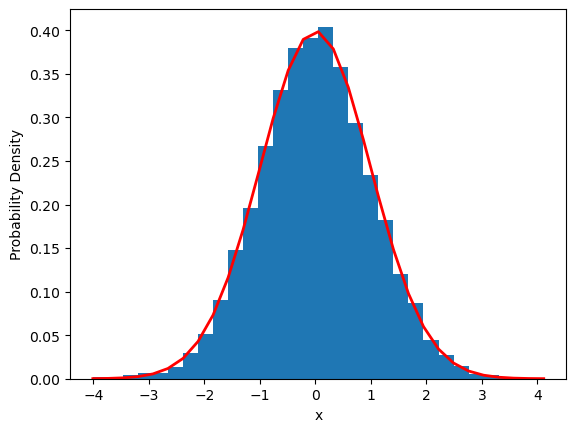

In [2]:
# set mean and stardard deviation
mu, sigma = 0, 1 # mean and standard deviation
# generate randam number of 10000
s = np.random.normal(mu, sigma, 10000)
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.show()

### 2D Gaussian Distribution
Now, let us extend the idea of Gaussian distribution to high dimensions. The distribution for multiple dimensions ($d$) is expressed as 

$p({\bf x};{\bf \mu},{\bf \Sigma})=\frac{1}{|{\bf\Sigma}|^{1/2}(2\pi)^{d/2}}e^{-\frac{1}{2}({\bf x}-{\bf\mu})^T\cdot{\bf \Sigma}^{-1}\cdot({\bf x}-{\bf\mu})}$

Below, we showcase 2D distribution in terms of ($x_1,x_2$)

In the csae 1, we have ${\bf \mu}=[0, 0]$ and ${\bf \Sigma}=[1,0;0,1]$.

In the csae 2, we have ${\bf \mu}=[0, 1]$ and ${\bf \Sigma}=[1,0.5;0.5,1]$.

/tmp/ipykernel_5535/1351203760.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pdf[i,j] = multivariate_normal(


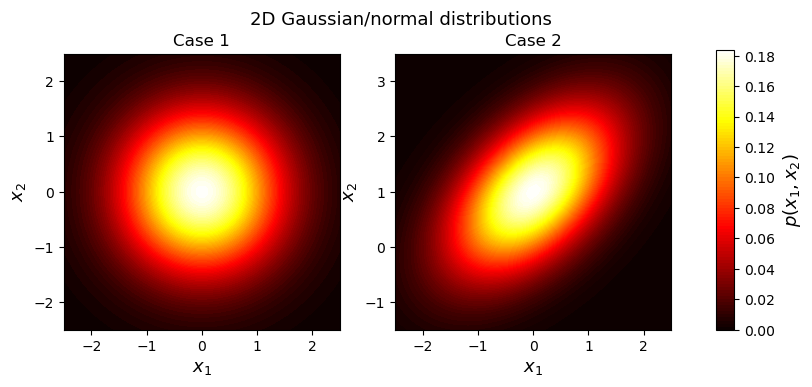

In [3]:
import sys
import matplotlib
from matplotlib import cm # Colormaps
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

# sns.set_style('darkgrid')
np.random.seed(42)


def multivariate_normal(x, d, mean, covariance):
    """pdf of the multivariate normal distribution."""
    x_m = x - mean
    return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) * 
            np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))

# Plot bivariate distribution
def generate_surface(mean, covariance, d):
    """Helper function to generate density surface."""
    nb_of_x = 100 # grid size
    x1s = np.linspace(-5, 5, num=nb_of_x)
    x2s = np.linspace(-5, 5, num=nb_of_x)
    x1, x2 = np.meshgrid(x1s, x2s) # Generate grid
    pdf = np.zeros((nb_of_x, nb_of_x))
    # Fill the cost matrix for each combination of weights
    for i in range(nb_of_x):
        for j in range(nb_of_x):
            pdf[i,j] = multivariate_normal(
                np.matrix([[x1[i,j]], [x2[i,j]]]), 
                d, mean, covariance)
    return x1, x2, pdf  # x1, x2, pdf(x1,x2)

# subplot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
d = 2  # number of dimensions

# Plot of independent Normals
bivariate_mean = np.matrix([[0.], [0.]])  # Mean
bivariate_covariance = np.matrix([
    [1., 0.], 
    [0., 1.]])  # Covariance
x1, x2, p = generate_surface(
    bivariate_mean, bivariate_covariance, d)
# Plot bivariate distribution
con = ax1.contourf(x1, x2, p, 100, cmap=cm.hot)
ax1.set_xlabel('$x_1$', fontsize=13)
ax1.set_ylabel('$x_2$', fontsize=13)
ax1.axis([-2.5, 2.5, -2.5, 2.5])
ax1.set_aspect('equal')
ax1.set_title('Case 1', fontsize=12)

# Plot of correlated Normals
bivariate_mean = np.matrix([[0.], [1.]])  # Mean
bivariate_covariance = np.matrix([
    [1., 0.5], 
    [0.5, 1.]])  # Covariance
x1, x2, p = generate_surface(
    bivariate_mean, bivariate_covariance, d)
# Plot bivariate distribution
con = ax2.contourf(x1, x2, p, 100, cmap=cm.hot)
ax2.set_xlabel('$x_1$', fontsize=13)
ax2.set_ylabel('$x_2$', fontsize=13)
ax2.axis([-2.5, 2.5, -1.5, 3.5])
ax2.set_aspect('equal')
ax2.set_title('Case 2', fontsize=12)

# Add colorbar and title
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(con, cax=cbar_ax)
cbar.ax.set_ylabel('$p(x_1, x_2)$', fontsize=13)
plt.suptitle('2D Gaussian/normal distributions', fontsize=13, y=0.95)
plt.show()
#

### Conditional Probability Distribution 

Now we understand how the Gaussian distribution. Let us look at the definiation of conditional probability distribution. This is the central idea behind GPs.  Here, we use 2D distribution to demonstrate the idea: $p(x_1|x_2)$ and $p(x_2|x_1)$. Therefore, based on the Bayes theorem, we have

$p(x_1|x_2)=\frac{p(x_1,x_2)}{p(x_2)}$

and

$p(x_2|x_1)=\frac{p(x_1,x_2)}{p(x_1)}$


/tmp/ipykernel_5535/1351203760.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pdf[i,j] = multivariate_normal(


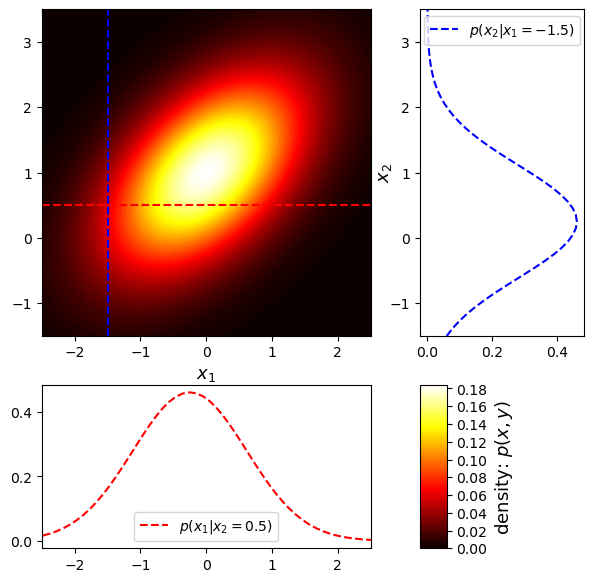

In [4]:
# 1D Normal distribution
def univariate_normal(x, mean, variance):
    """pdf of the univariate normal distribution."""
    return ((1. / np.sqrt(2 * np.pi * variance)) * 
            np.exp(-(x - mean)**2 / (2 * variance)))

d = 2  # dimensions
mean = np.matrix([[0.], [1.]])
cov = np.matrix([
    [1, 0.5], 
    [0.5, 1]
])


# Get the mean values from the vector
mean_x = mean[0,0]
mean_y = mean[1,0]
# Get the blocks (single values in this case) from 
#  the covariance matrix
A = cov[0, 0]
B = cov[1, 1]
C = cov[0, 1]  # = C transpose in this case

# Calculate x|y
y_condition = 0.5  # To condition on y
mean_xgiveny = mean_x + (C * (1/B) * (y_condition - mean_y))
cov_xgiveny = A - C * (1/B) * C

# Calculate y|x
x_condition = -1.5  # To condition on x
mean_ygivenx = mean_y + (C * (1/A) * (x_condition - mean_x))
cov_ygivenx = B - (C * (1/A) * C)

# Plot the conditional distributions
fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(
    2, 2, width_ratios=[2, 1], height_ratios=[2, 1])
# gs.update(wspace=0., hspace=0.)
# plt.suptitle('Conditional distributions', y=0.93)

# Plot surface on top left
ax1 = plt.subplot(gs[0])
x, y, p = generate_surface(mean, cov, d)
# Plot bivariate distribution
con = ax1.contourf(x, y, p, 100, cmap=cm.hot)
# y=1 that is conditioned upon
ax1.plot([-2.5, 2.5], [y_condition, y_condition], 'r--')
# x=-1. that is conditioned upon
ax1.plot([x_condition, x_condition], [-1.5, 3.5], 'b--')
ax1.set_xlabel('$x_1$', fontsize=13)
ax1.set_ylabel('$x_2$', fontsize=13)
ax1.yaxis.set_label_position('right')
ax1.axis([-2.5, 2.5, -1.5, 3.5])

# Plot y|x
ax2 = plt.subplot(gs[1])
yx = np.linspace(-5, 5, num=100)
pyx = univariate_normal(yx, mean_ygivenx, cov_ygivenx)
# Plot univariate distribution
ax2.plot(pyx, yx, 'b--', 
         label=f'$p(x_2|x_1={x_condition:.1f})$')
ax2.legend(loc=9)
# ax2.set_xlabel('density', fontsize=13)
ax2.set_ylim(-1.5, 3.5)

# Plot x|y
ax3 = plt.subplot(gs[2])
xy = np.linspace(-5, 5, num=100)
pxy = univariate_normal(xy, mean_xgiveny, cov_xgiveny)
# Plot univariate distribution
ax3.plot(xy, pxy, 'r--', 
         label=f'$p(x_1|x_2={y_condition:.1f})$')
ax3.legend(loc=0)
# ax3.set_ylabel('density', fontsize=13)
ax3.yaxis.set_label_position('right')
ax3.set_xlim(-2.5, 2.5)

# Clear axis 4 and plot colarbar in its place
ax4 = plt.subplot(gs[3])
ax4.set_visible(False)
divider = make_axes_locatable(ax4)
cax = divider.append_axes('left', size='20%', pad=0.05)
cbar = fig.colorbar(con, cax=cax)
cbar.ax.set_ylabel('density: $p(x, y)$', fontsize=13)
plt.show()
#

## Gaussian Processes for Regression
The GPs provides both the prediction and undertainty. In general, the observation could be assumed with/without noise, which can be handled by GPs. Before demonstrating the idea of GPs, we should note following important points:


1.   The prior distribution often assumes zero mean ($\mu=0$)
2.   The variance function is specified by the kernel function. Here, we use RBF.
3.   In the following code, we use parameter $s$ to specify whether we consider the noise for the data ($s=0$: no noise; $s\neq0$: with noise).

This module illustrates how one can write a GP code from scratch. In the next section, we proceed to use Sklearn to demonstrate the same idea.


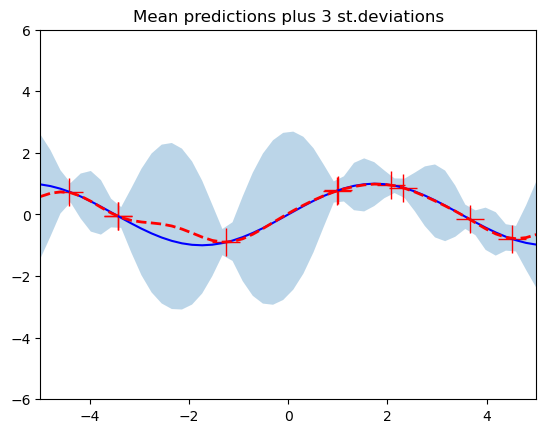

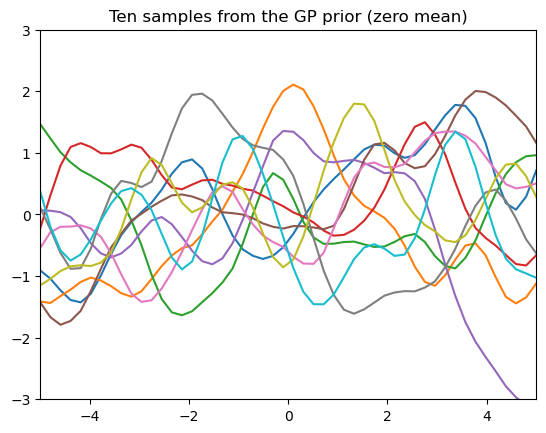

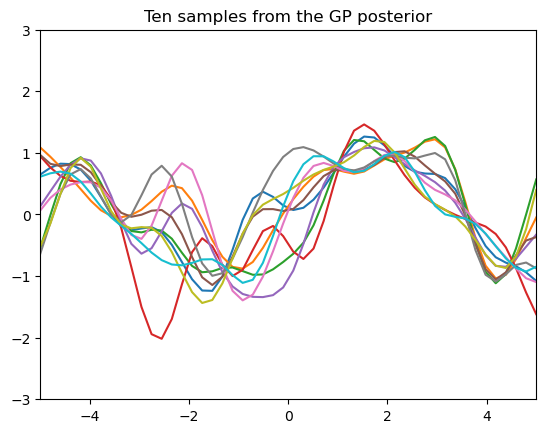

In [5]:
from __future__ import division

""" This is code for simple GP regression. It assumes a zero mean GP Prior """
np.random.seed(42) # for reproducibility

# This is the true unknown function we are trying to approximate
# Or you can specifi any function that you prefer
f = lambda x: np.sin(0.9*x).flatten()


# Define the kernel
def kernel(a, b):
    """ GP squared exponential kernel """
    # you can control the kernal parameters here
    kernelParameter = 0.5
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/kernelParameter) * sqdist)

N = 10         # number of training points.
n = 50         # number of test points.
sy = 0.01       # noise variance.

# Sample some input points and noisy versions of the function evaluated at
# these points. 
X = np.random.uniform(-5, 5, size=(N,1))
y = f(X) + sy*np.random.randn(N)

K = kernel(X, X)
L = np.linalg.cholesky(K + sy*np.eye(N))

# points we're going to make predictions at.
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

Lk = np.linalg.solve(L, kernel(X, Xtest)) # Inv(L)*kernel(X, Xtest)
# compute the mean at our test points.
mu = np.dot(Lk.T, np.linalg.solve(L, y))

# compute the variance at our test points.
K_ = kernel(Xtest, Xtest)

# variance
s2 = np.diag(K_) - np.sum(Lk**2, axis=0)
# stardard deviation
s = np.sqrt(s2)


# PLOTS:
plt.figure(1)
plt.clf()
plt.plot(X, y, 'r+', ms=20)
plt.plot(Xtest, f(Xtest), 'b-')
plt.gca().fill_between(Xtest.flat, mu-3*s, mu+3*s, alpha=0.3)
plt.plot(Xtest, mu, 'r--', lw=2)
plt.savefig('predictive.png', bbox_inches='tight')
plt.title('Mean predictions plus 3 st.deviations')
plt.axis([-5, 5, -6, 6])
plt.show()

# draw samples from the prior at our test points.
L = np.linalg.cholesky(K_ + sy**2*np.eye(n))
f_prior = np.dot(L, np.random.normal(size=(n,10)))
plt.figure(2)
plt.clf()
plt.plot(Xtest, f_prior)
plt.title('Ten samples from the GP prior (zero mean)')
plt.axis([-5, 5, -3, 3])
plt.savefig('prior.png', bbox_inches='tight')
plt.show()

# draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,10)))
plt.figure(3)
plt.clf()
plt.plot(Xtest, f_post)
plt.title('Ten samples from the GP posterior')
plt.axis([-5, 5, -3, 3])
plt.savefig('post.png', bbox_inches='tight')

plt.show()

### GPs using Sklearn
In most situation, we do not necessarily write the program as Sklearn already provides the subroutine. In the following, we will demonstrate idea using Sklearn.

In the following demonstration, we take a look at


1.   Different kernal specified by Sklearn (RFB, RationalQuadratic)
2.   For now, we specify the optimizer as 'None' such that they would use same hyper parameter for prior and posterior distribution. 



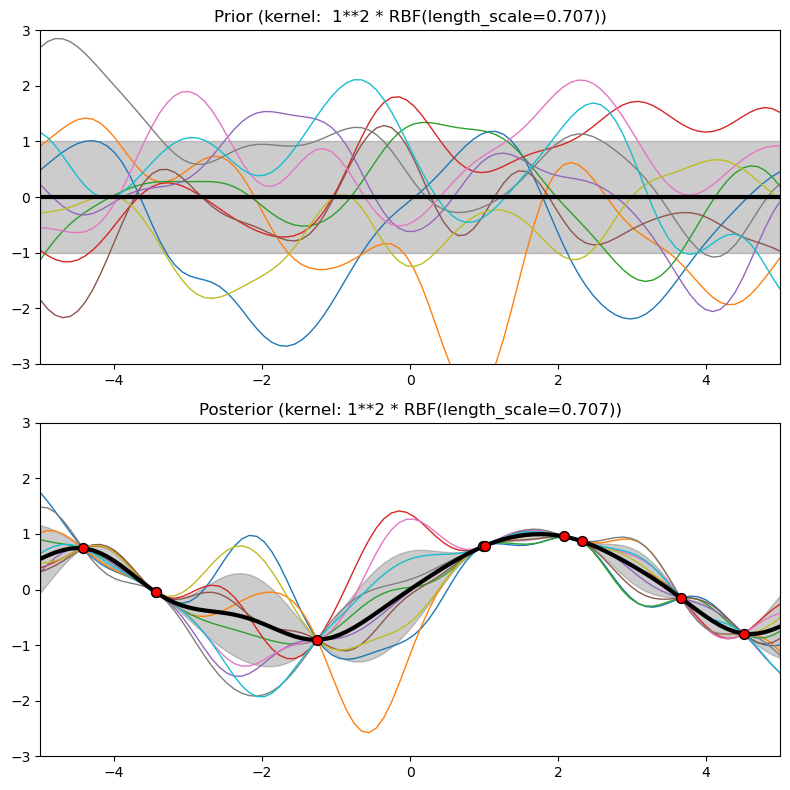

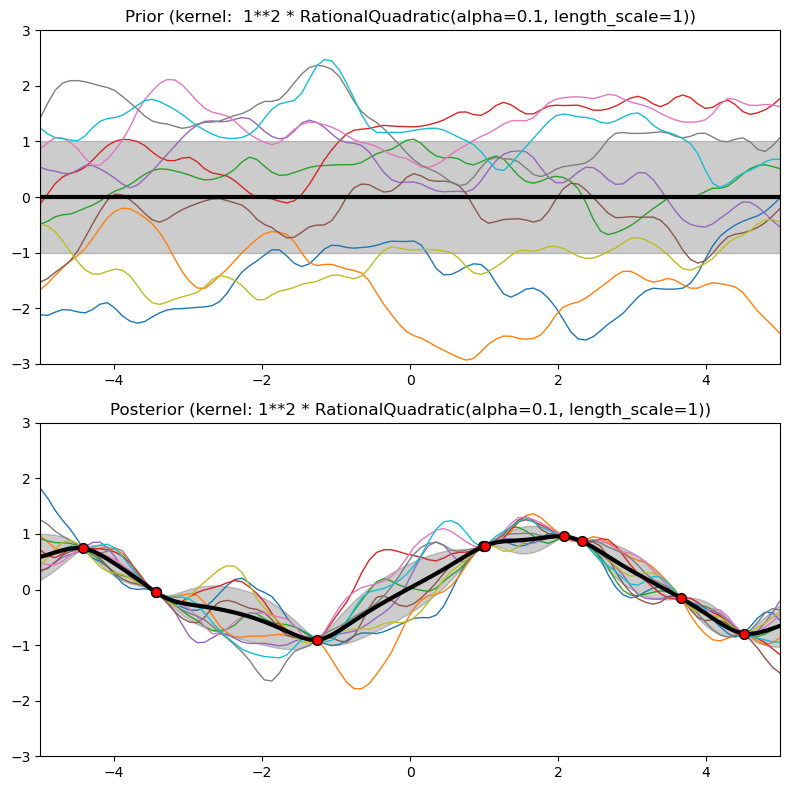

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, RationalQuadratic)

# we will use same true function as before
np.random.seed(42)

# This is the true unknown function we are trying to approximate
# Or you can specifi any function that you prefer
f = lambda x: np.sin(0.9*x).flatten()
N = 10         # number of training points.
# n = 50         # number of test points.
s = 0.0       # noise variance.

# Sample some input points and noisy versions of the function evaluated at
# these points. 
X = np.random.uniform(-5, 5, size=(N,1))
y = f(X) + s*np.random.randn(N)

kernels = [1.0 * RBF(length_scale=0.5**0.5, length_scale_bounds=(1e-1, 10.0)),
           1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1)]

for kernel in kernels:
    # Specify Gaussian Process
    gp = GaussianProcessRegressor(kernel=kernel,optimizer=None)

    # Plot prior
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    X_ = np.linspace(-5, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')
    y_samples = gp.sample_y(X_[:, np.newaxis], 10)
    plt.plot(X_, y_samples, lw=1)
    plt.xlim(-5, 5)
    plt.ylim(-3, 3)
    plt.title("Prior (kernel:  %s)" % kernel, fontsize=12)

    # Generate data and fit GP
    # rng = np.random.RandomState(4)
    # X = rng.uniform(0, 5, 10)[:, np.newaxis]
    # y = np.sin((X[:, 0] - 2.5) ** 2)
    gp.fit(X, y)

    # Plot posterior
    plt.subplot(2, 1, 2)
    X_ = np.linspace(-5, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')

    y_samples = gp.sample_y(X_[:, np.newaxis], 10)
    plt.plot(X_, y_samples, lw=1)
    plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
    plt.xlim(-5, 5)
    plt.ylim(-3, 3)
    plt.title("Posterior (kernel: %s)"
              % (gp.kernel_),
              fontsize=12)
    plt.tight_layout()

plt.show()


## Summary
The Gaussian Processes predicts the distribution of the function $f$ such that it noly only predicts the value but also its variance. This interesting idea enables many applications (e.g. active learning).

<b>Pros:</b> For regression analysis, GPs provides the error bound (variance); also, GP is a very powerful tool for both linear and non-linear relation. 

<b>Cons:</b> The approach is rather time consuming for high dimensional problem.

